# Gaertner L116A Ellipsometer

**Scott Prahl**

**May 2020**

**Version 3**

In [52]:
%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#import IPython.display

import pypolar.ellipsometry as ell
import pypolar.gaertner as gaertner

m_bk7 = complex(1.5151,0)     # index of BK7 at 632.8nm
m_si = complex(3.875, -0.023) # index of crystalline silicon at 632.8nm

# some data to work with
analyzer_deg = np.linspace(0,355,72)
analyzer = np.radians(analyzer_deg)

static_signal = np.array([3477,3768,4009,4371,4744,5126,5512,5891,6243,6635,6908,7209,7443,7582,7705,7684,7675,7415,7209,6845,6465,5996,5562,5166,4718,4420,4086,3782,3524,3292,3076,2993,2956,2948,3067,3230,3408,3711,4000,4389,4793,5193,5585,5973,6364,6667,7010,7206,7352,7492,7505,7588,7432,7338,7169,6855,6604,6162,5813,5315,4907,4501,4091,3784,3457,3246,3097,3012,2960,3046,3092,3268])
def fake_signal():
    return static_signal/2+np.random.normal(0,200,72)

def fake_No_QWP_signal(theta_p,rho):
    return 400+ell.rotating_analyzer_signal_from_rho(analyzer,rho,theta_p,average=1000,QWP=False,noise=100)

## Hardware

This only of interest to the Oregon Tech students.

Our Gaertner L116A ellipsometer was made in 1978.  Since the computer that was attached to this ellipsometer is long gone, we programmed an Arduino to serve as its computer interface.  The Arduino collects 72 data points from one rotation of the ellipsometer analyzer.  This array is sent over the USB serial connection to a host computer running a Jupyter notebook.

<img src="https://omlc.org/~prahl/host/453/week3/ellipsometer.jpg" width="50%">

## Optical Elements

<img src="https://omlc.org/~prahl/host/453/week3/image-A-0014.png" width="50%">

In [47]:
print(m_si)

rho = ell.rho_from_m(m_si, theta_i)
ell.m_from_rho(rho, theta_i)

(3.875-0.023j)


(3.874999999999989-0.022999999999999934j)

359.9° and 40.7
179.9° and 40.7


<IPython.core.display.Javascript object>


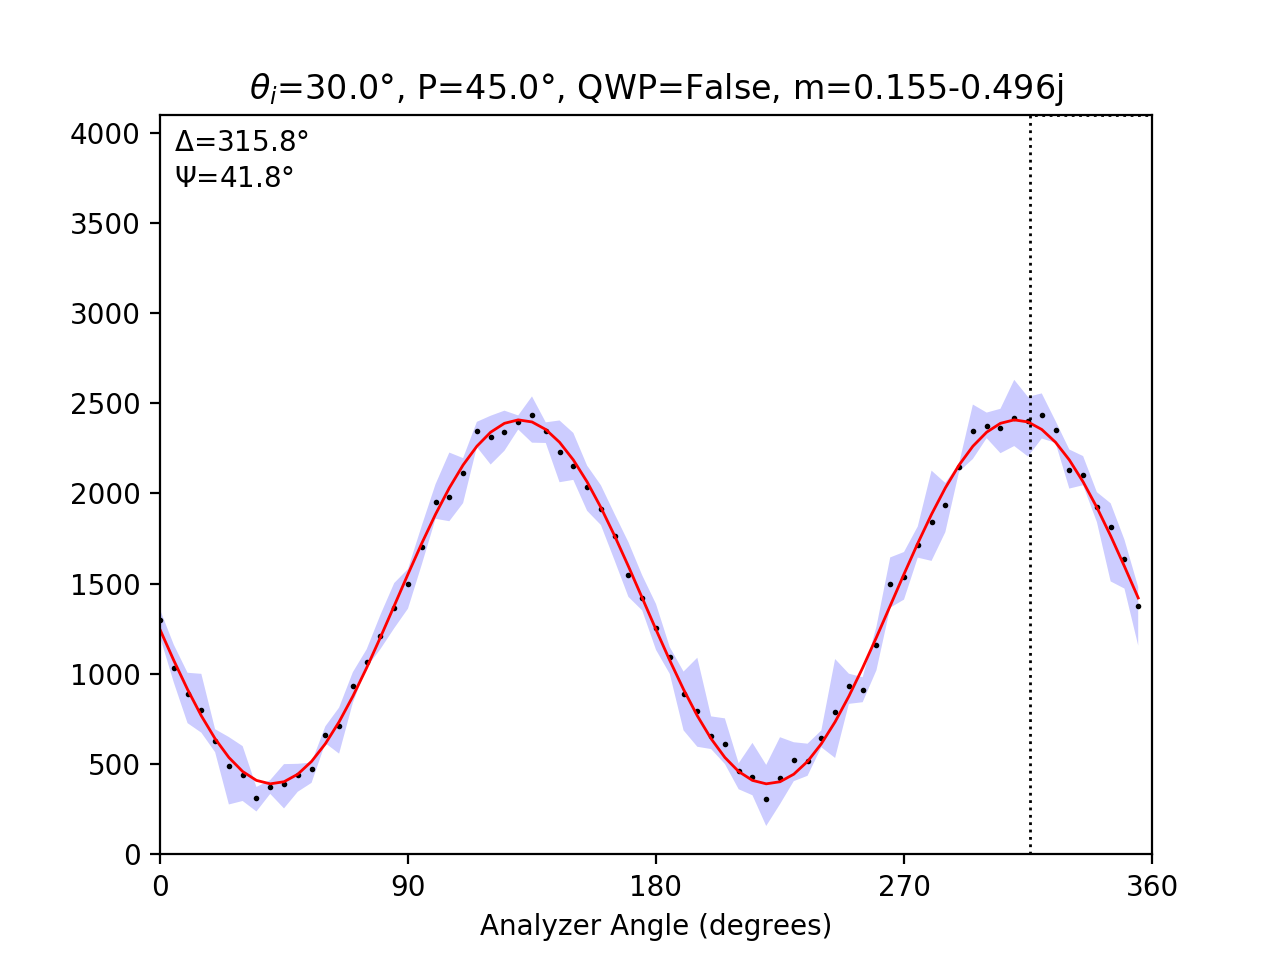

In [54]:
rho = ell.rho_from_m(m_si, theta_i)
tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
DeltaD = np.degrees(Delta)
PsiD = np.degrees(np.arctan(tanpsi))
print("%.1f° and %.1f" % (DeltaD, PsiD))
DeltaD = np.degrees(np.angle(rho))
PsiD = np.degrees(np.arctan(np.abs(rho)))
print("%.1f° and %.1f" % (DeltaD, PsiD))


def update(frame, theta_i, theta_p, QWP):
    i = frame % N
    rho = ell.rho_from_m(m_si, theta_i)

    ydata[i] = fake_No_QWP_signal(theta_p, rho)

    lo = np.min(ydata,axis=0)
    hi = np.max(ydata,axis=0)
    signal = np.mean(ydata,axis=0)
    rho = ell.rho_from_rotating_analyzer_data(analyzer, signal, theta_p, QWP=QWP)
    tanpsi, Delta = ell.tanpsi_Delta_from_rho(rho)
    DeltaD = np.degrees(Delta)

    avg = signal.mean()
    fitted = ell.rotating_analyzer_signal_from_rho(analyzer,rho,theta_p,average=avg, QWP=QWP)
    m = ell.m_from_rho(rho, theta_i)
    
    lines[0].set_data(analyzer_deg, signal)
    lines[1].set_data(analyzer_deg, fitted)
    lines[2].set_data([DeltaD,DeltaD,DeltaD+180,DeltaD+180],[0,4096,4096,0])

    ax.collections.clear()
    ax.fill_between(analyzer_deg, lo, hi, facecolor='blue', alpha=0.2)
    str = r"$\theta_i$=%.1f°, P=%.1f°, QWP=%r, m=%.3f%+.3fj" % (I,P,QWP,m.real,m.imag)
    Delta_label.set_text(r"$\Delta$=%.1f°" % DeltaD)
    Psi_label.set_text(r"$\Psi$=%.1f°" % np.degrees(np.arctan(tanpsi)))

    ax.set_title(str)
    return lines

N=5
I=30
P=45
QWP=False

ydata = np.empty((N,72))
theta_i = np.radians(I)
theta_p = np.radians(P)

fig = plt.figure()
ax = plt.axes(xlim=(0, 360), ylim=(0,4096))
Delta_label = ax.text(5,3900,r"$\Delta$")
Psi_label = ax.text(5,3700,r'$\psi')
plt.xlabel('Analyzer Angle (degrees)')
plt.xticks([0,90,180,270,360])

# set up the lines that will be dynamically updated
lines = [ax.plot([],[],'ko',markersize=1)[0],
         ax.plot([],[],'r',lw=1)[0],
         ax.plot([],[],':k',lw=1)[0]
        ]

ani = animation.FuncAnimation(fig, update, interval=500, fargs=[theta_i, theta_p, QWP])


In [94]:
fig.savefig('yourfilename.png')

### Establishing a connection to the ellipsometer

You must establish serial communication between your computer and the Arduino.
**To do this you need to know the name of the serial connection.**

One way to figure our the right name is to list the current serial ports on your computer:  `gaerter.current_serial_ports()` returns such a list.

Of course, if the ellipsometer is not plugged into the computer then the proper serial port will not appear.

In [ ]:
s = gaertner.current_serial_ports()
print(s)

In [ ]:
### Identify the port that is connected to the Arduino
### Copy that portname and port connected to the Ardunio string from above as the correct serial port id below

id = '/dev/cu.usbmodemFA141'   # UPDATE ME

conn = gaertner.connect_to_ellipsometer(id)

### Obtaining a signal

To acquire 72 equally spaced measurements as the analyzer is rotated, just do
```
signal=get_reflectance(conn)
```

## 30 degrees

In [ ]:
#glass
P = np.radians(45)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=False)

gaertner.save_data_with_name(signal, "glass", theta_i, P, QWP=False)
m = ell.m_from_rho(rho,theta_i)

plt.plot(degrees,signal,'x')
plt.title("m=%.4f%+.4fj" % (m.real,m.imag))
plt.show()

In [ ]:
P = np.radians(0)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.get_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=True)

gaertner.save_data_with_name(signal, "glass", np.degrees(theta_i), np.degrees(P), QWP=True)
m = ell.m_from_rho(rho,theta_i)

print(m)
plt.plot(signal)
plt.show()

In [ ]:
I_0, alpha, beta = ell.find_fourier(phi,signal)
fitted_signal = I_0*(1+alpha*np.cos(2*phi)+beta*np.sin(2*phi))

plt.plot(np.degrees(phi),fitted_signal, color='red')


plt.plot(np.degrees(phi),signal,'x')
plt.show()

In [ ]:
#silicon

P = np.radians(45)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=False)

gaertner.save_data_with_name(signal, "silicon", np.degrees(theta_i), np.degrees(P), QWP=False)
m = ell.m_from_rho(rho,theta_i)
print(m)

In [ ]:
P = np.radians(0)
degrees = np.linspace(0,360,num=72,endpoint=False)
phi = np.radians(degrees)
theta_i = np.radians(30)

signal = gaertner.avg_reflectance(conn)
rho = ell.rho_from_rotating_analyzer_data(phi, signal, P, QWP=True)

gaertner.save_data_with_name(signal, "siliconv", np.degrees(theta_i), np.degrees(P), QWP=True)
m = ell.m_from_rho(rho,theta_i)
print(m)